In [2]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import re
import unicodedata
import warnings
import copy
import statsmodels.formula.api as smf

In [3]:
sns.set(rc={'figure.figsize':(9,7)})

In [4]:
import nltk
nltk.download(["names", "stopwords","averaged_perceptron_tagger",
               "punkt", "vader_lexicon", "wordnet"], quiet=True)

True

In [5]:
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [11]:
df = pd.read_csv('gizmos_reviews.csv')

In [37]:
df = df[~pd.isna(df['description'])]
df['description'] = df['description'].apply(lambda x: x.lower())

In [12]:
def make_lemma(text):
  """
  Function to lemmatize and clean text
  
  From: https://towardsdatascience.com/from-dataframe-to-n-grams-e34e29df3460
  """
  word_lemma = nltk.stem.WordNetLemmatizer()
  stopwords_ = nltk.corpus.stopwords.words('english')
  stopwords_.extend(['gizmos', 'feel', 'like', 'game', 'board', 'dont',
                     'bit', 'get', 'really', 'much', 'also', 'well', 'lot'])
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split() 
  word_li = [word_lemma.lemmatize(word) for word in words if word not in stopwords_]

  # One last move: will replace building with builder, since there's no distinction in this case
  # This is also a very commong word in the corpus
  word_li = ['builder' if word == 'building' else word for word in word_li] 

  # For some reason, stopwords isn't removing this one. Doing so manually
  if 'game' in word_li:
    word_li.remove('game')

  return word_li

In [53]:
def dataframe_to_wordlist(df, word_col):
    all_text = ''

    for i in range(len(df)):
        new_text = df.iloc[i, word_col]
        #print(new_text)
        all_text += ' ' + new_text

    all_text = all_text.encode("ascii", errors="ignore").decode()
    for symbol in ['!', ',','.','_', '(', ')']:
        all_text = all_text.replace(symbol, ' ')
    
    all_text = all_text.lower()
    return all_text.split(' ')

In [28]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

In [188]:
df['word_col'] = df['description'].apply(lambda x: make_lemma(x))

In [189]:
df.head(10)

,game_id,rating,user,description,word_col
0,246192,6.0,3davoli,for sale,[sale]
1,246192,8.0,4ndrewcol3,my favorite shorter game,"[favorite, shorter]"
2,246192,6.0,Abdul,decent but forgettable. i would have expected ...,"[decent, forgettable, would, expected, least, ..."
3,246192,10.0,AbleCompany,my pick for an engine building game with just ...,"[pick, engine, builder, right, kind, theming, ..."
4,246192,7.0,Abruptdolphin,slimbo,[slimbo]
5,246192,7.0,Achire,light game. pretty fun with all the card combo...,"[light, pretty, fun, card, combo, mechanic, ma..."
6,246192,8.0,Acoidan85,grintxitos,[grintxitos]
7,246192,7.5,adamdynris,boardgamebliss dec. 2018,"[boardgamebliss, dec, 2018]"
8,246192,8.0,adamgospod,w koszulkach,"[w, koszulkach]"
9,246192,6.0,adamredwoods,1 play / 3 players (1 child) like: engine bui...,"[1, play, 3, player, 1, child, engine, builder..."


In [190]:
backup_df = copy.deepcopy(df)

In [191]:
full_word_str = []
for x in range(len(df)):
    for word in df.iloc[x,4]:
        full_word_str.append(word)

In [197]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=3,max_features=100)
vectorizer.fit(full_word_str)
feature_li = vectorizer.get_feature_names()
len(feature_li)

100

In [223]:
bow_df = copy.deepcopy(df)

In [225]:
bow_df['bow_col'] = df['word_col'].apply(lambda x: ' '.join(x))

In [226]:
bow_df.head()

,game_id,rating,user,description,word_col,bow_col
0,246192,6.0,3davoli,for sale,[sale],sale
1,246192,8.0,4ndrewcol3,my favorite shorter game,"[favorite, shorter]",favorite shorter
2,246192,6.0,Abdul,decent but forgettable. i would have expected ...,"[decent, forgettable, would, expected, least, ...",decent forgettable would expected least name v...
3,246192,10.0,AbleCompany,my pick for an engine building game with just ...,"[pick, engine, builder, right, kind, theming, ...",pick engine builder right kind theming accessi...
4,246192,7.0,Abruptdolphin,slimbo,[slimbo],slimbo


In [227]:
X = vectorizer.transform(bow_df['bow_col'])

In [228]:
item_li = [''] * 100
for value, idx in vectorizer.vocabulary_.items():
    item_li[idx] = value
len(item_li)

100

In [230]:
bow_df = pd.DataFrame(X.toarray())
bow_df.columns = item_li

In [231]:
bow_df[bow_df['ability'] > 0].head()

,ability,action,add,always,another,az,ball,best,better,build,...,think,though,time,turn,und,use,want,way,work,would
14,1,0,3,0,1,0,0,0,1,3,...,5,0,1,2,0,0,1,3,2,3
21,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
132,4,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
183,1,2,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
295,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


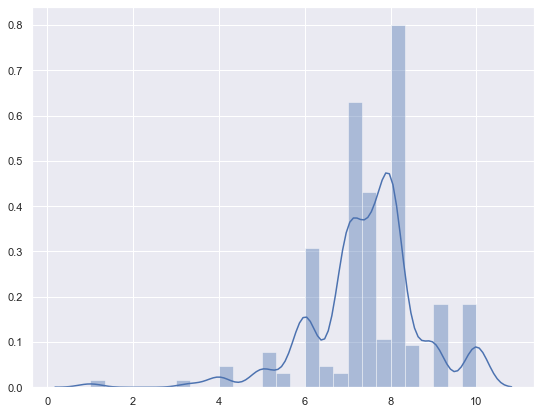

In [257]:
sns.distplot(df.loc[bow_df.loc[bow_df.sum(axis=1) == 0].index, 'rating'].values)

In [118]:
df.iloc[21,3]

"gismos feels like a lighter version of terraforming mars in terms of an engine builder. a card-and-marble engine building game where you can chain/domino abilities. the marbles might initially think of a kid's game, but there is a good bit of strategy to make an efficient engine work towards earning you points and not just spinning its wheels.  terraforming mars feels like it is a more mature game with more depth, but gizmos is easier to get to the table for a family. if you enjoy engine builders, gizmos is a great addition as a lightweight introductory game that will still be fun after the initial play."

In [232]:
X_train, y_train = bow_df.iloc[:700, :], df.loc[:700-1,'rating']
X_test, y_test = bow_df.iloc[700:, :], df.loc[700:,'rating']

In [233]:
len(X_test), len(y_test)

(323, 323)

In [234]:
# Random Forsts are notoriously bad with sparse data, but let's start easy
from sklearn.ensemble import RandomForestRegressor

In [235]:
rf = RandomForestRegressor(max_depth=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [236]:
pred_df = pd.DataFrame(data={'actual':y_test, 'preds':preds, 'naive': y_train.mean()})

In [237]:
from sklearn.metrics import mean_squared_error
print('model error:', mean_squared_error(pred_df['actual'], pred_df['preds']))
print('naive error:', mean_squared_error(pred_df['actual'], pred_df['naive']))

model error: 1.6856852499046828
naive error: 1.7024290100104065


Not a very large gain

In [238]:
# Random Forsts are notoriously bad with sparse data, but let's start easy
from sklearn.ensemble import GradientBoostingRegressor

In [239]:
gb = GradientBoostingRegressor()

In [258]:
gb = GradientBoostingRegressor(max_depth=10)
gb.fit(X_train, y_train)
preds = gb.predict(X_test)

In [259]:
pred_df = pd.DataFrame(data={'actual':y_test, 'preds':preds, 'naive': y_train.mean()})

In [260]:
from sklearn.metrics import mean_squared_error
print('model error:', mean_squared_error(pred_df['actual'], pred_df['preds']))
print('naive error:', mean_squared_error(pred_df['actual'], pred_df['naive']))

model error: 1.9752293418111282
naive error: 1.7024290100104065


In [261]:
from sklearn.linear_model import Lasso

In [285]:
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)
preds = lasso.predict(X_test)

In [286]:
pred_df = pd.DataFrame(data={'actual':y_test, 'preds':preds, 'naive': y_train.mean()})
print('model error:', mean_squared_error(pred_df['actual'], pred_df['preds']))
print('naive error:', mean_squared_error(pred_df['actual'], pred_df['naive']))

model error: 1.7024290100104065
naive error: 1.7024290100104065


In [179]:
# Needs work! Probably too many useless features

## TFIDF

In [288]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=3,max_features=100)
vectorizer.fit(full_word_str)
feature_li = vectorizer.get_feature_names()
len(feature_li)

100

In [267]:
tf_df = copy.deepcopy(df)

In [269]:
tf_df['tf_col'] = tf_df['word_col'].apply(lambda x: ' '.join(x))

In [270]:
X_0 = vectorizer.transform(tf_df['tf_col'])

In [272]:
item_li = [''] * 100
for value, idx in vectorizer.vocabulary_.items():
    item_li[idx] = value
len(item_li)

100

In [273]:
tf_df = pd.DataFrame(data=X_0.toarray(),columns = item_li)

In [275]:
X_train, y_train = bow_df.iloc[:700, :], df.loc[:700-1,'rating']
X_test, y_test = bow_df.iloc[700:, :], df.loc[700:,'rating']

In [276]:
rf = RandomForestRegressor(max_depth=10)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

In [277]:
pred_df = pd.DataFrame(data={'actual':y_test, 'preds':preds, 'naive': y_train.mean()})

In [278]:
from sklearn.metrics import mean_squared_error
print('model error:', mean_squared_error(pred_df['actual'], pred_df['preds']))
print('naive error:', mean_squared_error(pred_df['actual'], pred_df['naive']))

model error: 1.7118465034915356
naive error: 1.7024290100104065


In [293]:
feature_df = pd.DataFrame(data={'feature': X_train.columns,'importance':rf.feature_importances_})
feature_df.sort_values('importance', ascending=False,inplace=True)
feature_df.head(10)

,feature,importance
55,marble,0.047366
64,play,0.043860
42,great,0.043122
44,interesting,0.042927
38,gimmick,0.042173
92,time,0.041277
80,similar,0.034755
67,playing,0.028301
79,see,0.027437
70,pretty,0.026736


In [306]:
important_features = feature_df[feature_df['importance'] >= 0.01]
important_features = important_features['feature'].values

In [346]:
X_train, y_train = tf_df.loc[:700-1, important_features], df.loc[:700-1,'rating']
X_test, y_test = tf_df.loc[700:, important_features], df.loc[700:,'rating']

In [347]:
len(X_train), len(y_train), len(X_test), len(y_test)

(700, 700, 323, 323)

In [348]:
gb.fit(X_train, y_train)
preds = gb.predict(X_test)
pred_df = pd.DataFrame(data={'actual':y_test, 'preds':preds, 'naive': y_train.mean()})

In [361]:
from sklearn.svm import SVR
svr = SVR(kernel='linear', C=1)
svr.fit(X_train, y_train)
preds = svr.predict(X_test)
pred_df = pd.DataFrame(data={'actual':y_test, 'preds':preds, 'naive': y_train.mean()})
print('model error:', mean_squared_error(pred_df['actual'], pred_df['preds']))
print('naive error:', mean_squared_error(pred_df['actual'], pred_df['naive']))

model error: 1.653057258889836
naive error: 1.7024290100104065


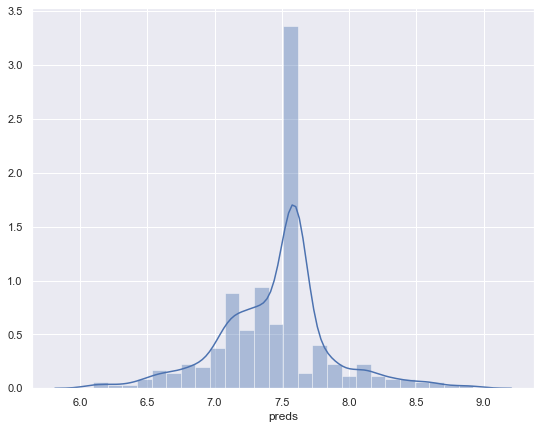

In [354]:
sns.distplot(pred_df['preds'])